<a href="https://colab.research.google.com/github/Gaurav7888/RecSys/blob/main/Recommendation_system_using_NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip archive.zip

In [21]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
from collections import defaultdict

In [5]:
import pandas as pd

u_cols =  ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/content/ml-100k/u.user', sep='|', names=u_cols,
encoding='latin-1')

n_users = users.shape[0]
print('Number of users:', n_users)

Number of users: 943


In [6]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [16]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings = pd.read_csv('../content/ml-100k/ua.base', sep='\t', names=r_cols, encoding='latin-1')
ratings_test = pd.read_csv('../content/ml-100k/ua.test', sep='\t', names=r_cols, encoding='latin-1')



print('Number of traing rates:', ratings.shape[0])
print('Number of test rates:', ratings_test.shape[0])

Number of traing rates: 90570
Number of test rates: 9430


In [17]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [18]:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('../content/ml-100k/u.item', sep='|', names=i_cols,encoding='latin-1')

n_items = movies.shape[0]
print("Number of items:",n_items)

Number of items: 1682


In [19]:
movies.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


<Axes: >

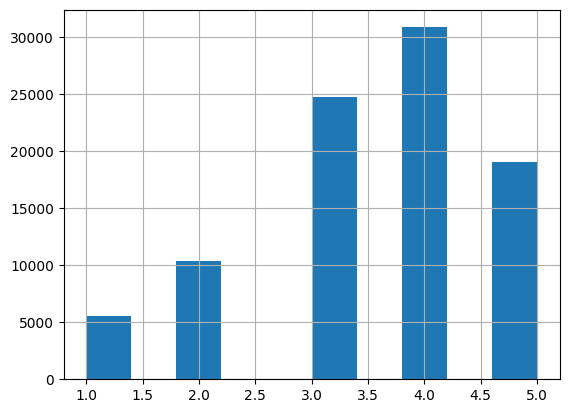

In [20]:
ratings.rating.hist()

In [22]:
ratings.sample(1)

,user_id,movie_id,rating,unix_timestamp
84599,882,427,5,879877026


In [23]:
ratings.nunique()

user_id             943
movie_id           1680
rating                5
unix_timestamp    46638
dtype: int64

array([[<Axes: title={'center': 'movie_id'}>]], dtype=object)

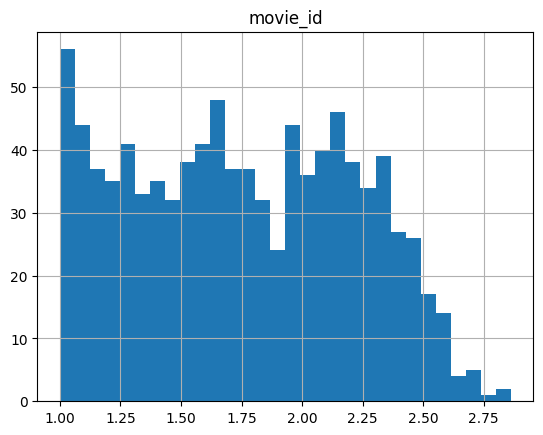

In [25]:
np.log10(ratings.groupby("user_id").agg({"movie_id":len})).hist(bins=30)

array([[<Axes: title={'center': 'user_id'}>]], dtype=object)

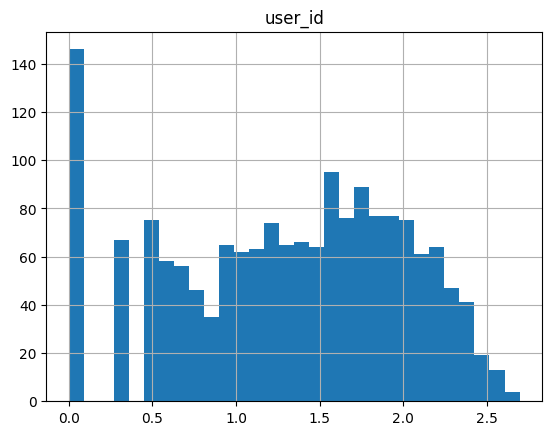

In [26]:
np.log10(ratings.groupby("movie_id").agg({"user_id":len})).hist(bins=30)

In [22]:
#Importing the libraries
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages
from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
#from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.python_splitters import python_chrono_split,python_stratified_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k,
                                                     recall_at_k, get_top_k_items)
print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Pandas version: 1.5.3
Tensorflow version: 2.15.0


In [ ]:
!pip install git+https://github.com/microsoft/recommenders.git

In [25]:
# read Record dataset
record_df = pd.read_excel("/content/Rec_sys_data.xlsx")
#read Customer Dataset
customer_df = pd.read_excel("/content/Rec_sys_data.xlsx", sheet_name = 'customer')
# read product dataset
prod_df = pd.read_excel("/content/Rec_sys_data.xlsx", sheet_name = 'product')

In [26]:
print(record_df.head())
print(customer_df.head())
print(prod_df.head())

   InvoiceNo StockCode  Quantity         InvoiceDate        DeliveryDate  \
0     536365    84029E         6 2010-12-01 08:26:00 2010-12-02 08:26:00   
1     536365     71053         6 2010-12-01 08:26:00 2010-12-02 08:26:00   
2     536365     21730         6 2010-12-01 08:26:00 2010-12-03 08:26:00   
3     536365    84406B         8 2010-12-01 08:26:00 2010-12-03 08:26:00   
4     536365     22752         2 2010-12-01 08:26:00 2010-12-04 08:26:00   

   Discount%        ShipMode  ShippingCost  CustomerID  
0       0.20      ExpressAir         30.12       17850  
1       0.21      ExpressAir         30.12       17850  
2       0.56     Regular Air         15.22       17850  
3       0.30     Regular Air         15.22       17850  
4       0.57  Delivery Truck          5.81       17850  
   CustomerID  Gender  Age  Income  Zipcode Customer Segment
0       13089    male   53    High     8625   Small Business
1       15810  female   22     Low    87797   Small Business
2       15556  fem

In [27]:
#selecting columns
df = record_df[['CustomerID','StockCode','Quantity','DeliveryDate']]
#dropping the StockCodes (item ids) that are string for this experiment, as NCF only takes integer ids
df["StockCode"] = df["StockCode"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
# dropping nulls
df = df.dropna()
print(df.shape)


(246706, 4)


<ipython-input-27-31fee32bcbb0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["StockCode"] = df["StockCode"].apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna()


In [28]:
df.head()

,CustomerID,StockCode,Quantity,DeliveryDate
1,17850,71053.0,6,2010-12-02 08:26:00
2,17850,21730.0,6,2010-12-03 08:26:00
4,17850,22752.0,2,2010-12-04 08:26:00
7,17850,22633.0,6,2010-12-04 08:28:00
8,17850,22632.0,6,2010-12-03 08:28:00


In [29]:
#header=["userID", "itemID", "rating", "timestamp"]
df = df.rename(columns={
    'CustomerID':"userID",'StockCode':"itemID",'Quantity':"rating",'DeliveryDate':"timestamp"
})

In [30]:
df["userID"] = df["userID"].astype(int)
df["itemID"] = df["itemID"].astype(int)

In [31]:
train, test = python_chrono_split(df, 0.75)


In [32]:
train_file = "./train.csv"
test_file = "./test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [35]:
#top k items to recommend
TOP_K = 10
# Model parameters
EPOCHS = 50
BATCH_SIZE = 256
SEED = 42
#preparing the data
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)
# training NCF model
model = NCF (
    n_users=data.n_users,
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)
#adding timer for training.
with Timer() as train_time:
    model.fit(data)
print("Took {} seconds for training.".format(train_time))
#adding timimg for predictions
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))
    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})
    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)
print("Took {} seconds for prediction.".format(test_time))

100%|██████████| 3498/3498 [02:08<00:00, 27.12it/s]
/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Took 1873.8730 seconds for training.
Took 84.4243 seconds for prediction.


In [36]:
# Evaluate model
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.025707
NDCG:	0.077707
Precision@K:	0.051630
Recall@K:	0.057502


In [37]:
df_order = pd.read_excel('/content/Rec_sys_data.xlsx', 'order')
df_customer = pd.read_excel('/content/Rec_sys_data.xlsx', 'customer')
df_product = pd.read_excel('/content/Rec_sys_data.xlsx', 'product')

In [38]:
#select columns
all_predictions = all_predictions[['userID','itemID','prediction']]
# rename columns
all_predictions = all_predictions.rename(columns={
   "userID":'CustomerID',"itemID":'StockCode',"rating":'Quantity','prediction':'probability'
})

In [39]:
def recommend_product(customer_id):
  print(" \n---------- Top 5 Bought StockCodes -----------\n")
  print(df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity'))
  top_5_bought = df_order[df_order['CustomerID']==customer_id][['CustomerID','StockCode','Quantity']].nlargest(5,'Quantity')
  print('\n-------Product Name of bought StockCodes ------\n')
  print(df_product[df_product.StockCode.isin(top_5_bought.StockCode)]['Product Name'])
  print("\n --------- Top 5 Recommendations ------------ \n")
  print(all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability'))
  recommend = all_predictions[all_predictions['CustomerID']==customer_id].nlargest(5,'probability')
  print('\n-------Product Name of Recommendations ------\n')
  print(df_product[df_product.StockCode.isin(recommend.StockCode)]['Product Name'])

In [40]:
recommend_product(13137)


 
---------- Top 5 Bought StockCodes -----------

        CustomerID StockCode  Quantity
234414       13137     84077        48
234443       13137     23321        13
50797        13137     21985        12
234404       13137     22296        12
234418       13137     22297        12

-------Product Name of bought StockCodes ------

70      MightySkins Skin Decal Wrap Compatible with Li...
490           Window Tint Film Mitsubishi (all doors) DIY
694     Harriton Men's Paradise Short-Sleeve Performan...
1065    MightySkins Skin For Samsung Galaxy J3 (2016),...
1339    MightySkins Skin Decal Wrap Compatible with Le...
Name: Product Name, dtype: object

 --------- Top 5 Recommendations ------------ 

         CustomerID  StockCode  probability
1512160       13137      20724     0.959677
1511921       13137      22383     0.956518
1512164       13137      20723     0.923569
1511841       13137      47566     0.903266
1511859       13137      22961     0.891937

-------Product Name of Recom